In [1]:
import os
import sys
import time

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from src import utils
from src import bilstm
import src.dataset as dset
import src.pytorch_utils as ptu
import src.chu_liu_edmonds as chu

import warnings
warnings.filterwarnings('ignore')

seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(seed)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)
models_path = 'models'

cpu


In [2]:
train_dataset = dset.DataSet('data/train.labeled', tqdm_bar=True)
test_dataset = dset.DataSet('data/test.labeled', train_dataset=train_dataset, tqdm_bar=True)
comp_dataset = dset.DataSet('data/comp.unlabeled', train_dataset=train_dataset, tagged=False, tqdm_bar=True)

100%|██████████| 24744/24744 [00:03<00:00, 8086.90it/s]


In [3]:
version = 'V1_final'
checkpoint = ptu.load_model(version=version, models_path=models_path, epoch='best', seed=42)
checkpoint.log

model version: V1_final
Number of parameters 2097001 trainable 2097001
epochs: 9
train_time: 5.298

last train_loss: 0.37867
last val_loss: 0.54361
last train_score: 0.88470
last val_score: 0.84169
best val_score: 0.84169 at epoch 9


,train_time,timestamp,train_loss,val_loss,train_score,val_score,batch_size,best,amsgrad,betas,eps,lr,weight_decay
1,0.595500,10:52:47 20-06-2020,1.091428,1.101946,0.679897,0.677821,16,True,False,"(0.9, 0.999)",1.000000e-08,0.0010,0
2,1.197251,10:53:23 20-06-2020,0.716564,0.741159,0.785029,0.778212,16,True,False,"(0.9, 0.999)",1.000000e-08,0.0010,0
3,1.805150,10:53:59 20-06-2020,0.570776,0.625771,0.830350,0.813690,16,True,False,"(0.9, 0.999)",1.000000e-08,0.0010,0
4,2.417346,10:54:36 20-06-2020,0.488264,0.579202,0.851980,0.825899,16,True,False,"(0.9, 0.999)",1.000000e-08,0.0010,0
5,3.019799,10:55:12 20-06-2020,0.432093,0.556340,0.866794,0.834039,16,True,False,"(0.9, 0.999)",1.000000e-08,0.0010,0
6,3.582923,10:55:48 20-06-2020,0.402475,0.539058,0.877912,0.839836,64,True,False,"(0.9, 0.999)",1.000000e-08,0.0004,0
7,4.161895,10:56:23 20-06-2020,0.392691,0.538397,0.880968,0.840699,64,True,False,"(0.9, 0.999)",1.000000e-08,0.0004,0
8,4.729946,10:56:57 20-06-2020,0.385230,0.541059,0.882562,0.840987,64,True,False,"(0.9, 0.999)",1.000000e-08,0.0004,0
9,5.298406,10:57:31 20-06-2020,0.378670,0.543614,0.884705,0.841686,64,True,False,"(0.9, 0.999)",1.000000e-08,0.0004,0


In [4]:
_, score, y_pred, _ = checkpoint.predict(test_dataset.dataset,
                                                 batch_size=32,
                                                 device=device,
                                                 results=True,
                                                 decision_func=chu.test_chu_liu_edmonds)
test_dataset.insert_predictions(preds=y_pred, name='test_m1')
print(f'chu_liu_edmonds_UAS: {score}')
print(test_dataset.get_UAS())

100%|██████████| 25325/25325 [00:11<00:00, 2236.36it/s]


chu_liu_edmonds_UAS: 0.8425077081192189
0.8425077081192189


In [5]:
_, _, y_pred, _ = checkpoint.predict(comp_dataset.dataset,
                                                 batch_size=32,
                                                 device=device,
                                                 results=True,
                                                 decision_func=chu.test_chu_liu_edmonds)
comp_dataset.insert_predictions(preds=y_pred, name='comp_m1')

100%|██████████| 24744/24744 [00:17<00:00, 1386.65it/s]


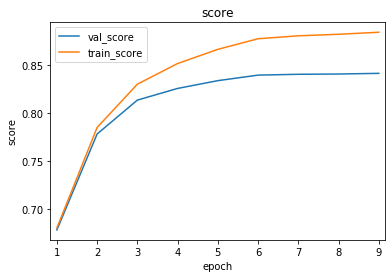

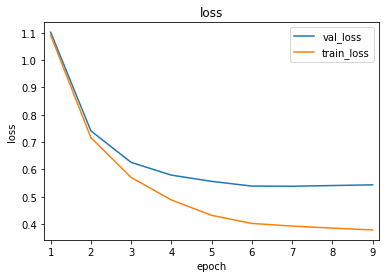

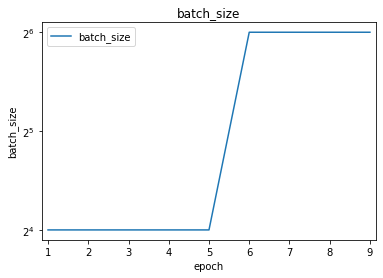

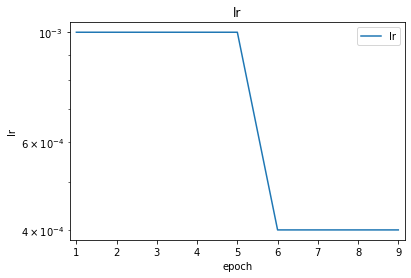

In [6]:
checkpoint.plot_checkpoint(['val_score', 'train_score'], 'score', 'score', scale='linear', basey=10)
checkpoint.plot_checkpoint(['val_loss', 'train_loss'], 'loss', 'loss', scale='linear', basey=10)
checkpoint.plot_checkpoint(['batch_size'], 'batch_size', 'batch_size', scale='log', basey=2)
checkpoint.plot_checkpoint(['lr'], 'lr', 'lr', scale='log', basey=10)